# Module 5, Week 2 In Class Exercise

Probability distributions and hypothesis testing

**Before class reading: Chapters 11.3 from Data8 textbook and Shearer and Stark (2014)**

**Last week we:**
- Review some key statistics topics: samples versus populations and empirical versus theorectical distributions
- Simulate a head/tail coin toss i.e. Binomial distribution
- Simulate cars passing a point i.e. Poisson distribution
- Simulate geomagnetic polarity reversals i.e. Gamma distribution

**Our goals for today:**
- Be the unsung heros of the scientific method, the Reproducers!
- Reproduce portions of Shearer, P. M., & Stark, P. B. (2012). Global risk of big earthquakes has not recently increased. _Proceedings of the National Academy of Sciences_, 109(3), 717-721.
- Compute the probability that there has been a recent increase in the number of large EQ.
- Test the hypothesis that main stock earthquakes are Poissonian.

## Setup

Run this cell as it is to setup your environment.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as scipy
from scipy import stats
import datetime
import time


The data we will use is a global catalog of all M≥7.0 earthquake events, downloaded from USGS: https://earthquake.usgs.gov/earthquakes/search/

The columns are: time, latitude, longitude, depth, mag, magType, nst, gap, dmin, rms, net, id, updated, place, type, horizontalError, depthError, magError, magNst, status, locationSource, magSource

We don't need most of these columns and can drop them.

### Load and cleanup data

In [17]:
data=pd.read_csv('query.csv')
raw_eq_data=data.drop(['nst','gap','dmin','rms','net','id','type',
                       'horizontalError','depthError','magError','magNst','status',
                       'locationSource','magSource'], axis=1)
raw_eq_data.head()

,time,latitude,longitude,depth,mag,magType,updated,place
0,1900-07-29T06:59:00.000Z,-10.0,165.0,0.0,7.6,mw,2015-05-13T18:52:41.000Z,Santa Cruz Islands
1,1900-10-09T12:28:00.000Z,60.0,-142.0,0.0,7.7,mw,2018-01-09T23:39:24.583Z,Southeastern Alaska
2,1900-10-29T09:11:00.000Z,11.0,-66.0,0.0,7.7,mw,2015-05-13T18:52:41.000Z,"offshore Miranda, Venezuela"
3,1901-08-09T13:01:00.000Z,-22.0,170.0,0.0,7.9,mw,2015-05-13T18:52:41.000Z,southeast of the Loyalty Islands
4,1901-08-09T18:33:00.000Z,40.0,144.0,0.0,7.5,mw,2015-05-13T18:52:41.000Z,"off the east coast of Honshu, Japan"


Declare variables which we will use further.

In [3]:
lat=raw_eq_data.latitude.values
lon=raw_eq_data.longitude.values
mag=raw_eq_data.mag.values
dates=raw_eq_data.time.values

Convert the string in the 'time' column to a datetime object.

In [4]:
date_time_obj_1 = datetime.datetime.strptime(dates[0], '%Y-%m-%dT%H:%M:%S.%fZ')
date_time_obj_1.year

1900

Build a timeline of event occurrence times in days since first event.

In [5]:
nevt = len(dates) # number of raw events
days=np.zeros(nevt) # initialize the size of the array days
# convert string in time column to datetime objects and 
# calculate number of days from first event (i.e. make a days numberline)
for i in np.arange(0,nevt,1):    
    date_time_obj = datetime.datetime.strptime(dates[i], '%Y-%m-%dT%H:%M:%S.%fZ')
    d0 = datetime.date(date_time_obj_1.year, date_time_obj_1.month, date_time_obj_1.day)
    d1 = datetime.date(date_time_obj.year, date_time_obj.month, date_time_obj.day)
    delta = d1 - d0
    days[i]=delta.days # fill days in with the number of days since the first event (7/1/1911)

Plot the raw catalog days vs. magnitude, and print the number of events.

Number of events before declustering: 1367


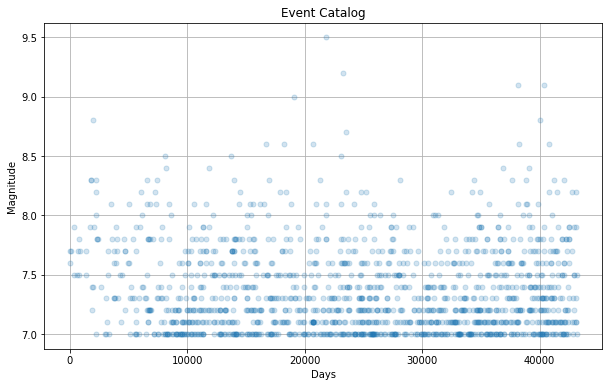

In [6]:
#Plot Catalog
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(days,data.mag,'o',alpha=0.2,markersize=5)
ax.set(xlabel='Days', ylabel='Magnitude',
       title='Event Catalog')
ax.grid()

print('Number of events before declustering: %4i' %(nevt))

### Decluster Catalog

We'll decluster our catalog following Shearer and Stark (2012):

"Because our focus here is on the global scale, we adopt the
conservative and simple approach of removing events for which
preceding larger earthquakes occur within 3 yr and 1,000 km. Declustering
in this manner removes many events that might not traditionally
be classified as aftershocks."

As we did back in Module 2b, we need a function to compute the great circle distance in km between geographic locations given in Lat,Lon:

In [7]:
#This function computes the spherical earth distance between to geographic points and is used in the
#declustering algorithm below
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    
    The first pair can be singular and the second an array

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) # convert degrees lat, lon to radians

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2  # great circle inside sqrt

    c = 2 * np.arcsin(np.sqrt(a))   # great circle angular separation
    km = 6371.0 * c   # great circle distance in km, earth radius = 6371.0 km
    return km

Now we'll decluster the catalog. The Dtest and Ttest are MUCH simpiler.

In [8]:
#Decluster the Catalog  Note: This cell may take a few minute to complete
cnt=0 # initialize a counting variable
save=np.zeros((1,10000000),dtype=int) # initialize a counting variable
for i in range(0,nevt,1):   # step through EQ catalog
    # definitions of Dtest and Ttest aftershock window bounds
    Dtest=1000   # distance bounds 1000 km
    Ttest=3*365.25  # aftershock time bounds 3 years
    
    a=days[i+1:nevt]-days[i]    # time interval in days to subsequent earthquakes in catalog
    m=mag[i+1:nevt]   # magnitudes of subsequent earthquakes in catalog
    b=haversine_np(lon[i],lat[i],lon[i+1:nevt],lat[i+1:nevt]) # distance in km to subsequent EQs in catalog
    
    icnt=np.count_nonzero(a <= Ttest)   # counts the number of potential aftershocks, 
                                        # the number of intervals <= Ttest bound
    if icnt > 0:  # if there are potential aftershocks
        itime=np.array(np.nonzero(a <= Ttest)) + (i+1) # indices of potential aftershocks <= Ttest bound
        
        for j in range(0,icnt,1):   # loops over the aftershocks         
            
            if b[j] <= Dtest and m[j] < mag[i]: # test if the event is inside the distance window 
                                                # and that the event is smaller than the current main EQ
                save[0][cnt]=itime[0][j]  # index value of the aftershock
                cnt += 1 # increment the counting variable

                
af_ind=np.delete(np.unique(save),0)   # This is an array of indexes that will be used to delete events flagged 
                                      # as aftershocks    


In [19]:
# delete the aftershock events
declustered_datetime =np.delete(dates,af_ind)
declustered_days=np.delete(days,af_ind)  #The aftershocks are deleted from the days array 
declustered_mag=np.delete(mag,af_ind)    #The aftershocks are deleted from the mag array 
declustered_lon=np.delete(lon,af_ind)    #The aftershocks are deleted from the lon array 
declustered_lat=np.delete(lat,af_ind)    #The aftershocks are deleted from the lat array 
n_main=len(declustered_days)

n_85 = len(declustered_mag[declustered_mag>=8.5])
days_85 = declustered_days[declustered_mag>=8.5]
n_8 = len(declustered_mag[declustered_mag>=8.0])
days_8 = declustered_days[declustered_mag>=8.0]
n_75 = len(declustered_mag[declustered_mag>=7.5])
days_75 = declustered_days[declustered_mag>=7.5]
print('There are %3i M≥8.5 events, %3i M≥8 events, %3i M≥7.5 events, and  %3i M≥7.0 events.'%(n_85, n_8, n_75, n_main))

There are  15 M≥8.5 events,  89 M≥8 events, 369 M≥7.5 events, and  759 M≥7.0 events.


The number of declustered events from Shearer and Stark (2012) were: 759 M≥7.0 events, 330 M≥7.5 events, 75 M≥8.0 events, 16 and M≥8.5 events. What are 2 causes for the difference between event counts? Hint 1: look at the date of the last event in our catalog and compare with the year Shearer and Stark's work was published. Hint 2: look at the "update" date for our catalog and compare with the year Shearer and Stark's work was published.

_Write your answer here._

### Magnitude Versus Time

Next we'll reconstruct Figure 1 from Shearer and Stark (2012).

"Fig. 1 shows earthquake magnitudes versus time and smoothed
yearly rates of M ≥ 8, M ≥ 7.5, and M ≥ 7 activity. As expected,
there are many more small earthquakes than large earthquakes,
consistent with a Gutenberg-Richter (GR) power law relationship.
The GR b value for the declustered catalog is approximately
1.3 for M ≥ 7.5 earthquakes. The eye is a poor judge of randomness 
and tends to find patterns in random sequences. Thus, the simple appearance of clustering should not be
considered convincing evidence for nonrandomness."

<img src="./figure1.png" width=600>

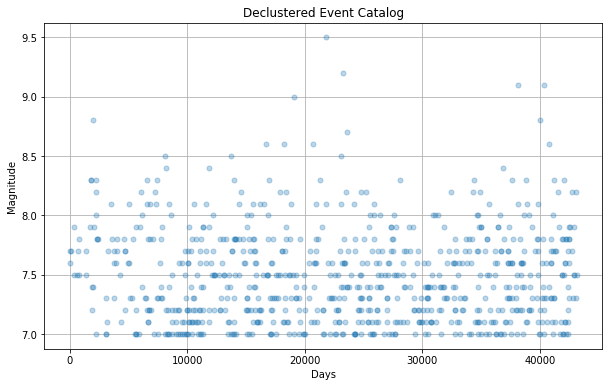

Number of events after declustering:  759


In [10]:
# (A) Global earthquake magnitudes since 1900 after regional declustering of events.
# Plot DeClustered Catalog
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(declustered_days, declustered_mag,'o',alpha=0.3,markersize=5)
ax.set(xlabel='Days', ylabel='Magnitude',
       title='Declustered Event Catalog')
ax.grid()
plt.show()

print('Number of events after declustering: %4i' %(n_main))

Panels B,C, and D are Yearly rates of M ≥ 8, M ≥ 7.5, and M ≥ 7 earthquakes. Rates are five-year running averages.

In [11]:
# Annual rates
num_years = 119;
years = np.arange(1900,2019,1)
annual_rate_7=np.zeros(num_years) # initialize the size of the array, and start count at zero
annual_rate_75=np.zeros(num_years) 
annual_rate_8=np.zeros(num_years) 
for i in np.arange(0,num_years,1):  
    for j in np.arange(0,n_main,1):
        # parse the year of each event 
        date_time_obj = datetime.datetime.strptime(declustered_datetime[j], '%Y-%m-%dT%H:%M:%S.%fZ')   
        if date_time_obj.year == years[i]:        
            annual_rate_7[i] = annual_rate_7[i]+1 # count up the events in each year
            if declustered_mag[j] >= 7.5:
                annual_rate_75[i] = annual_rate_75[i]+1 # count up the M≥7.5 events in each year
                if declustered_mag[j] >= 8.0:
                    annual_rate_8[i] = annual_rate_8[i]+1 # count up the M≥ 8 events in each year


#  5 year running average rates
avg_rate_7=np.zeros(num_years-4) # initialize the size of the array
avg_rate_75=np.zeros(num_years-4) 
avg_rate_8=np.zeros(num_years-4)   
# do the running average
for i in np.arange(2,num_years-2,1): 
    avg_rate_7[i-2]=np.mean(annual_rate_7[i-2:i+2])
    avg_rate_75[i-2]=np.mean(annual_rate_75[i-2:i+2])
    avg_rate_8[i-2]=np.mean(annual_rate_8[i-2:i+2])

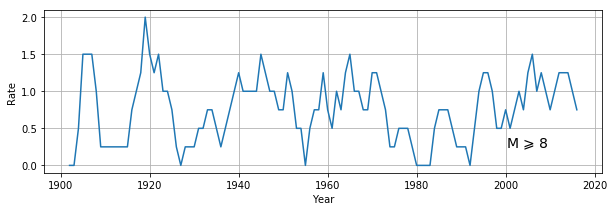

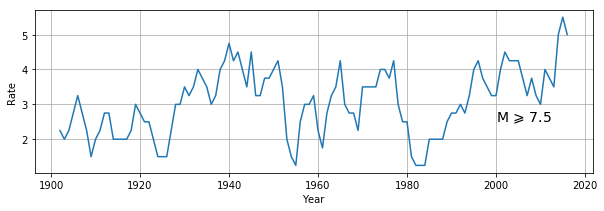

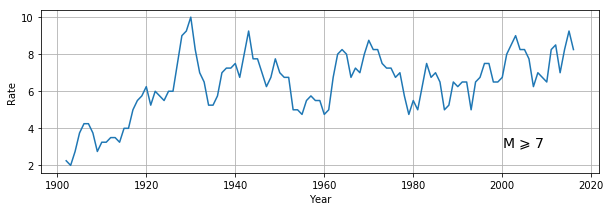

In [12]:
#Plot Rate of M>8.0 eq
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(years[2:-2], avg_rate_8,'-')
ax.set(xlabel='Year', ylabel='Rate')
plt.text(2000,0.25,'M $\geqslant$ 8',fontsize=14)
ax.grid()
plt.show()

#Plot Rate of M>7.5 eq
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(years[2:-2], avg_rate_75,'-')
ax.set(xlabel='Year', ylabel='Rate')
plt.text(2000,2.5,'M $\geqslant$ 7.5',fontsize=14)
ax.grid()
plt.show() 

#Plot Rate of M>7.0 eq
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(years[2:-2], avg_rate_7,'-')
ax.set(xlabel='Year', ylabel='Rate')
plt.text(2000,3,'M $\geqslant$ 7',fontsize=14)
ax.grid()
plt.show()

"Nonetheless, past researchers have pointed to several possibly
anomalous features that are visible in this plot. First, there were a
disproportionate number of very large M ≥ 8.5 earthquakes
between 1950 and 1965. Second, there was a dearth of such large
earthquakes in the 38 yr from 1966 to 2003. Finally, since 2004
there has been an elevated rate of M ≥ 8 earthquakes: The five year
running average is at a record high, although there have been
rates nearly as high in the past. These anomalies are evident only
for the largest earthquakes and are much weaker or absent for
smaller earthquakes. This observation implies that if the large
earthquake clustering is caused by a physical mechanism, the
mechanism must affect M ≥ 8 earthquakes without changing
the rate of smaller events. This property is inconsistent with
the triggering behavior implied by aftershock sequences, which
are observed to have Gutenberg-Richter magnitude-frequency
relationships reflecting a preponderance of smaller events."

Do you see these "anomalous features" in our catalog?

_Write your answer here._

### Monte Carlo Tests

Next we'll test how anomalous those features are by simulating random earthquake catalogs!

"How statistically significant are these anomalies for the large
earthquakes? Addressing this question is complicated by the fact
that virtually every realization of a random process will have features
that appear anomalous."

"We use Monte Carlo simulations to estimate the probability
both of the recent elevated rate of large earthquake activity and
of the gap that preceded it, under the null hypothesis that seismicity
follows a Poisson process that generates exactly as many
events as were in fact observed. That is, under the null hypothesis,
the number of events is given and the times of these events are
independent, identically distributed (iid) random variables, all
with a uniform distribution on the interval in days [0, 40,767].
Our estimates are based on 100,000 random catalogs simulated
from that joint distribution. The estimated probabilities are the
fractions of those 100,000 catalogs that have the apparent anomaly
at issue, for instance, the fraction that have at least a given
number of events within an interval of a specified length."

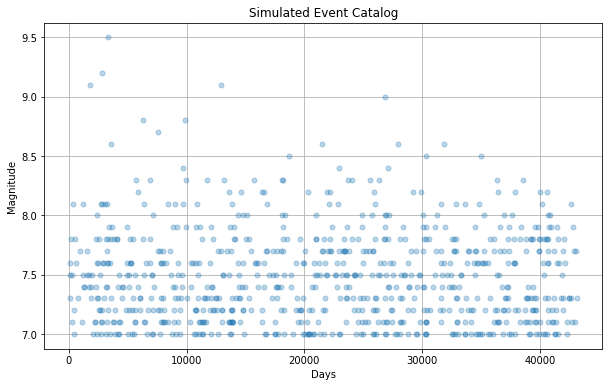

In [13]:
# One Monte Carlo simulation
# "the number of events is given" 
# use the same event magnitudes
sim_mag=declustered_mag

# "the times of the events are independent, identically distributed (iid) random variables"
# draw random occurance days from a uniform distribution
sim_days=np.random.uniform(0,declustered_days[-1],n_main)

#Sort events by sim_days
ind_d=np.argsort(sim_days)   #determine sort index
sim_days=sim_days[ind_d]     #apply sort index
sim_mag=sim_mag[ind_d]       #apply sort index

#Plot Simulated Catalog
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(sim_days, sim_mag,'o',alpha=0.3,markersize=5)
ax.set(xlabel='Days', ylabel='Magnitude',
       title='Simulated Event Catalog')
ax.grid()
plt.show()

That's one simulated catalog, now let's do a statistically significant number. And count the number of simulations that have at least nine of 89 (M ≥ 8) events occuring within 2,269 days of each other or that lack any M ≥ 8.5 events for a period of at least 40 years.

In [14]:
# 5000 Monte Carlo simulations
num_sims = 5000;
cnt_sims_1 = 0 # initialize count at zero
cnt_sims_3 = 0
for m in np.arange(0,num_sims,1):
    sim_mag=declustered_mag
    sim_days=np.random.uniform(0,declustered_days[-1],n_main) # draw random occurance days from a uniform distribution
    #Sort events
    ind_d=np.argsort(sim_days)   #determine sort index
    sim_days=sim_days[ind_d]     #apply sort index
    sim_mag=sim_mag[ind_d]       #apply sort index
    
    
    # Count the occurances of the anomalous features
    
    # Test 1: at least nine of 89 (M ≥ 8) events occur within 2,269 days of each other
    sim_days_8=sim_days[sim_mag>=8.0]
    for i in np.arange(0,n_8,1): # loop over the M ≥ 8 events
        a=sim_days_8[i+1:n_8]-sim_days_8[i] # days to subsequent 8.0 events
        n_8_2269_days = len(a[a<=2269]) # number of days within 2,269 days of current event
        if n_8_2269_days >= 9 : # if there are more than 9 events within 2,269 days count this sim and go to the next
            cnt_sims_1 = cnt_sims_1 +1
            break
        
    # Test 2: at least three of 15 (M ≥ 8.5) events occur within 2,266 days of each other
    # LEAVE FOR HW
    
    #Test 3: lack of M ≥ 8.5 events 40 yr gap
    sim_days_85=sim_days[sim_mag>=8.5]
    for k in np.arange(0,n_85-1,1): # loop over the M ≥ 8.5 events
        b=sim_days_85[k+1]-sim_days_85[k] # days to next 8.5 event
        n_85_gap_40year = len(b[b>=40*365.25]) # number of 8.5 events with 40 year gap (or more) until next event
        if n_85_gap_40year > 0 : # if there are ANY with 40 year gap until next event count this sim and go to the next
            cnt_sims_3 = cnt_sims_3 +1
            break
        
per_chance_1 = 100* cnt_sims_1/num_sims;
print('Under the null hypothesis, there is about a ', per_chance_1,'% chance that at least nine of 89 M≥8 events would occur within 2,269 days of each other.')

per_chance_3 = 100* cnt_sims_3/num_sims;
print('Under the null hypothesis, there is about a ', per_chance_3,'% chance that a 40 year gap between M≥8.5 events would occur.')



Under the null hypothesis, there is about a  80.8 % chance that at least nine of 89 M≥8 events would occur within 2,269 days of each other.
Under the null hypothesis, there is about a  2.38 % chance that a 40 year gap between M≥8.5 events would occur.


###  Tests of the Poisson Hypothesis

"A more general question is whether the earthquake catalog, after
removing regional clustering, is statistically distinguishable from a
realization of a homogenous Poisson process."

#### Test 1:  KS test that times are iid uniform random variables

"The first test compares the empirical distribution of the times
with the uniform distribution. For each magnitude threshold,
we determine the times of (locally declustered) events of that
magnitude or above. We then perform a Kolmogorov-Smirnov
(KS) test of the hypothesis that those times are a
sample of iid uniform random variables"

__2 Sample Kolmogorov-Smirnov (KS) test:__ The Kolmogorov–Smirnov test is a nonparametric test of if two sample distributions are drawn from the same distribution. The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution functions of the samples. 

<img src="./KS2_Example.png" width=600>
> Source: Wikipedia, https://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test


We will draw an empirical sample of occurance days from a uniform random distribution, and do a 2-Sample KS test comparing the random occurance days with the observed occurance days of the events in our declustered catalog. We'll use the function `scipy.stats.ks_2samp()` to perform the KS test. This function takes two distributions as input, and returns a D-statistic and p-value. The D-statistic is the cumulative distance between the CDFs of the two samples (black arrow in above figure). The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution. The p-value gives the probability that two samples drawn from the same distribution would have that D-statistic. You can reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is LESS than your significance level (1%, 5%, 10%, etc.). We will repeat this simulation 5000 times, and average the p-value results of the KS-test from all the simlations.

In [20]:
# Perform a KS test on decluster_days and uniformly distributed days
num_sims = 5000; #number of simulations
# initialize the size of the stats
D_ks_7 = np.zeros(num_sims)
pvalue_ks_7  = np.zeros(num_sims)
D_ks_8 = np.zeros(num_sims)
pvalue_ks_8  = np.zeros(num_sims)

# perform the simulations
for m in np.arange(0,num_sims,1):
    iid_days_7=np.random.uniform(0,declustered_days[-1],n_main) # occurance times drawn from uniform dist
    ind_d=np.argsort(iid_days_7)   #determine sort index
    iid_days_7=iid_days_7[ind_d]     #apply sort index
    # KS test for all M>7 events
    D_ks_7[m], pvalue_ks_7[m] = scipy.stats.ks_2samp(declustered_days,iid_days_7)
    

    iid_days_8=np.random.uniform(0,declustered_days[-1],n_8)# occurance times drawn from uniform dist
    ind_d=np.argsort(iid_days_8)   #determine sort index
    iid_days_8=iid_days_8[ind_d]     #apply sort index
    # KS test for M>8 events
    D_ks_8[m], pvalue_ks_8[m] =scipy.stats.ks_2samp(days_8,iid_days_8)


print('p-value for the M≥7 Kolmogorov-Smirnov test: %4.2f percent' %(np.mean(pvalue_ks_7)*100))
print('p-value for the M≥8 Kolmogorov-Smirnov test: %4.2f percent' %(np.mean(pvalue_ks_8)*100))


p-value for the M≥7 Kolmogorov-Smirnov test: 3.52 percent
p-value for the M≥8 Kolmogorov-Smirnov test: 60.35 percent


How do these p-values compare with those published in Shearer and Stark (2012)'s Table 1? Would you reject that the occurance days of our catalog are uniformly distributed (i.e. is the p-value less than say 1% meaning you are 99% confident they are not uniform)?

_Write your answer here._

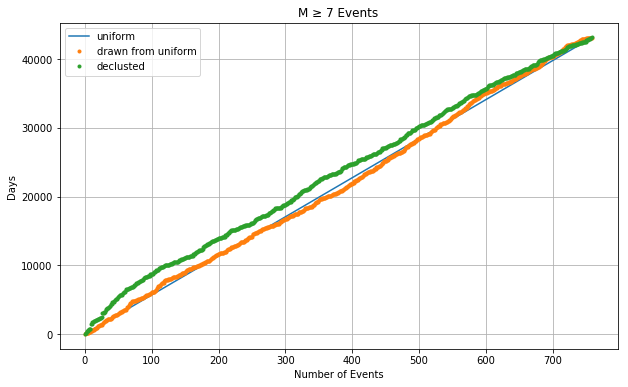

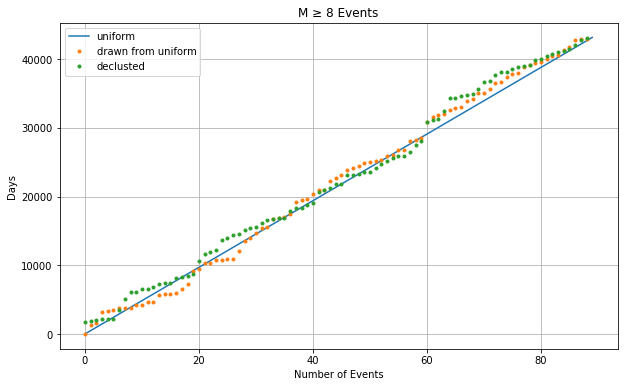

In [24]:
# plot the theoretical (uniform), sample (declustered), and empirical (drawn from uniform) cumulative distributions.
fig, ax = plt.subplots(figsize=(10,6))
ax.plot([0, n_main],[0, declustered_days[-1]],'-',label='uniform')
ax.plot(iid_days_7,'.',label='drawn from uniform')
ax.plot(declustered_days,'.',label='declusted')
ax.set(xlabel='Number of Events',ylabel='Days',title='M ≥ 7 Events')
plt.legend()
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([0, n_8],[0, declustered_days[-1]],'-',label='uniform')
ax.plot(iid_days_8,'.',label='drawn from uniform')
ax.plot(days_8,'.',label='declusted')
ax.set(xlabel='Number of Events',ylabel='Days',title='M ≥ 8 Events')
plt.legend()
ax.grid()
plt.show()

Do your KS test p-values corroborate what you observe from the CDFs? Does the M>7 catalog which gave a lower p-value look less uniform than the M>8 catalog?

_Write your answer here._

"Global clustering of large earthquakes is not statistically significant:
The data are statistically consistent with the hypothesis that
these events arise from a homogeneous Poisson process."

"Finally, of course,
even if the danger has not increased recently, that does not mean
that the ongoing danger is small or should be ignored."